In [1]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'iris:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F19%2F420%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240911%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240911T205742Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D83d0046ce43e97f0a14b81e0b14284755e81a2ad0f543464485f85157c367a4dd0e02c94d3a49d3b786c6da9bbdd41a9d88c88698fb53e796d3783340f02fee559001fde73e6c3f4cc25a48b11bf04fb637e63ec4127dd3b306d95f5bc38a8c3e8fd29303bd5c0ed8dc33f2938efa5d6fefc9cd673d3f89c8808c81b8c45d3978ce0306b430e1937496f01cfa26416a74498477be8dd303be6c11a5f89327f9b214f99ff7526c2181fbbfd45070dfda30622895c7265381331142138870ecd4f607bffca287d0100293a22e0ed3120b940559c6b1a8b58d7f51aa3afd080e304f6f64e022ebea5dc4c9c1e0c81575bee27dc8d81bccfbfdc46495b85f3dfd8d3,120-years-of-olympic-history-athletes-and-results:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F31029%2F40943%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240911%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240911T205742Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3Db39b582a554bd83ef79ed29d9c7ca7035c4ee2cdd548d5674f0afb33077b266b3526a2e1b55cba60ebd01e338bf139ad4c122f1ff3065ad897318c2bd3d89b662189e917777c68dbe8484bb5be402591f2fad3284e541a436bd15d57affd05f2874327d4649efb02a3dadcf77d85e6d78b16e3efc1c159e3b2ca69a963ab7959830870a23104ecb7a5824e13b3cf187b0998d87887a3e4ae2dcafd25d082b6e8f296732094a2a413b44111b60d84c521e67c78dcf06ac244469c6b2ee44854e9092478cd3eca370164e3d10ecff085b1ab1c1c25c2977f868f2248f8441e86067d8f10d7cd55cdd8a60fc637be3be5735bb597a8b7670db34d79d81e7cefb788,google-play-store-apps:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F49864%2F274957%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240911%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240911T205742Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D2023b6cd39cd17d3d28d78a7bf9c48641c688d33b60f54c0da63760ab87761a0c70028fa6fe9cca55a867aaa95035c3922236b066ff1b53d390403990c908d7b11a3234cc7b830c71260d54eec8eb4a4b70af89ceda5868da18436a27a9f3ddb17290f43bd8463b2088e690eefc5c0e21129bd880139fa153129932650d313741bd7506be739e080112cea2d1449d791d7ecf61d0e914fea9fb2e3593b7b4549643aafdf3660b3fd7585706d17cf2a2bbe69b0bedcfe97860b68cf58cd837414518c344c5b092fe4e60d3043476b16d3b117933b363710538473f6ad95382d71b575dc627981d2cb96519cdd0e3e3bc298e6328044ca106fd5f2500eb8ebfc0b,youtube-new:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F4549%2F466349%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240911%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240911T205742Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3Dbd0a13f57185aaf09d2536474646f832c5291362bbd630d298dd8ac083c7984176bb2a602bbaef38fdf584b24a236cf2c443d4fd14d2e6cea50fd9d5e4a7e7354f72496aa0db20d6083a5d08a81c4b8a7732852519910c9ea82c7bd44bfb85b893cbb08b8264580ce7ee96930e290f6265c7fb91f374e7d1e3f58104ebd1d6e66c67d945971827f7552073da32705ef8c23dfac8244ecb890e24be34e5455e7433e614742cce446087681fad6a4af33fcef7449a44d39fdb5afa076ea6653ee35b92c45386be3c971f042ad019ee50deb0457634be4f191a9568afffb6251cbbda02966a7d069ccbad0990a0eb68eaf2cf1264135b09740c19c4f0ca4c5287f0,us-police-shootings:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F806447%2F1382162%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240911%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240911T205742Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D02e38f14769018d5f768a5336036235edd2a1c5802b8dced0dce0dc0178b8c70cb0883833c93ddf1f8b619de83e8e086edc5de869d81ee941dce5301c0d38fbd97dfcf0db1df062b17e53eb1537eb364a13156bd4de4d2cbd8b16eec59a9c39f6fe197d8342371b59b02429c1277be71a9ac14a102ca03e996429560799e3b1b0282665837d90bbdcdfa7853ceaecc21b6dcc73652729286e8c67cd56812fce507917023dfa8fd82fb6dd891a0ae660ec0826c0f44b05ad160b1aa9a71075a566e469875358e95eb39c7de753c2ac7a449adba37cf70b474406f3e1cf750325226d400e5d0b45467a035e9df630275e97cbbe3eae99df12cda765003ff16c86c,av-healthcare-analytics-ii:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F849299%2F1448850%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240911%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240911T205742Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D22c33821136ef2763330ba4afa8f4b9918741dce159365f220066a1b569ef03a772d0ff3d73be022e795a51cf0f8740cf784486aa56bbc16f3dc50b670aecbb5f556539d936358a5ba3acbf8f4dcf98c29169603eb39ce976ff56e1cec65d420d90baa842351e2067718a619794e76aed1f49c6de24a2ba21546e197dfd7e4e1ebe74d10d898d65c36838cac26c1a178c980c985ff84b2e651f0679600668625fd927619c4e1ca6f94e2e7e5c1c124d6782f3a4b6be5ead631ff1105c9386e5c636e9d1388519811219f1f447743076eb179cb065bfef1db7a5a2a44bf9e57e9fd6a2c18b7cfaa3b34856b79544e4b942eafe0e37e1b11ec17ab46d20cbfe731,animal-crossing-new-horizons-nookplaza-dataset:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F661950%2F2314697%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240911%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240911T205743Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D903eb4f6081711f4c3c0fe6d2b68cf6ab7ffa08d63cc3ee923a528bdd230fb33a9e90a8ecd2ed15ba52c08da8deffd4119f25f0a1886acc7bcd888942e4216e42eeed9d56cdc7af7635cd03910cfb6e0f534beef36bee4588d628341a0a2e011d5f0b1a47ee85f188fb24ac8ca96f1c052f90070fe08a6f149a0a293d50c07ced6cbbeec96d6a06438a9e8ce6cde4d8816e1b288d025045d69f082d82d5f21c1101ad30546c677723a537d2543442bf755c6673189c33478c3be1a55168c65a9f58aaaa55c8e861f2a6dad48c393b01a32298d9dc875cb0063fb46bcf890e6fc14464d2422fe134c36f9b5737166cb8cc652a2632fc5685c826a24f6633c051b,novel-corona-virus-2019-dataset:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F494724%2F2364896%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240911%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240911T205743Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D798e4ecfa6072907d40f1faa83176dcb21468345c19f0df7f535547d8b48994ebe8bfeb1f7076fc2199fb3465db78bbacf9405971aa939d54355b64181b838e25b2eeff174d55480cfd4fefd3ec9bf9c50f444b01f87da145039adf45dbecca73a2b5b823eb277544c3376c42531d46986c5f09302bb1e3a648757954ffd4171fd81df63020531a58c4e19f52a4e5a21b0ab05768891461b49a021f1ddd978a3081c4b5e6429d27879f1397b4460dc4861980cf25b0f2206f530d2a27be743c0ed74527a8d8b4927e6ca32b83caaeb185f97c8d0c975715790dcc957faf8ed12a6f1dae2a6a2a4cf46701470b9e6fa02e246bf5e6dc7f52ddb93c0d30aa7f739,covid19-in-india:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F557629%2F2516524%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240911%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240911T205743Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D284f5637e20a3818f60297eca4a32c8fe2066d85027550362534238609379cec5e9ea82f2357856bd9892ea84e7b751d7ca5b79de36b280dc3e490aae007ca1bb5f2d885e24c4b4a92343bfcba9965513a2c4b3c7ef4f1dc0197890f81a30c9575957cd082cb03e1dd2d92eeb839d75aaeba5fa106f5a8758943b968c614ee4fa1a68db593b655642dd4da9c0477e5549037d1dd4e87420d4f867cefb0c127c3471f4288d444fb062f521ce0a00cebbd598506bc3fee0bf4bbcb2688ff57deb96983ae2f9e2d6fbdd9ec82a5b92eb995d794d08b654db5fcb33eebd749266a7aa8b5a1665d91c48b068edbf4a44ca32ee78467c3bf47ea5774eb1b9b8ad581f8,netflix-shows:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F434238%2F2654038%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240911%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240911T205743Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D3088776b3443eab8c7ee2f064adb7416963f5384b83f22fc448d3f7248b63dafc0fbbd971a80d07a310814ff86447c7ceaf56467d399fc2801675c34cee4cbf5de6d883c637ddbd86fbd745e51d5912980916ff50460ae8b0a5a3fe55abbd8fdff134961633d096d6177a14c61d50da390a057d1647a8f08be995c90ab222d446801ac9dcceda3344d0a8cb2dd63e6553091ecc561d2689bd2b209d19b5b67051db35c18b7945d3c1284fbd971fec2b44e5ca387afd25607b06450d8cd5d168d545428bf1cc88157d3463c12229efa9948ef3c58df9a1b827d825a8407b813f2ed20cce2cfac6acf5e58d221f96a579558083bfa3c6e37623fabf7e7a8b08293'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 3687 bytes downloaded
Downloaded and uncompressed: iris
[==================================================] 5690772 bytes downloaded
Downloaded and uncompressed: 120-years-of-olympic-history-athletes-and-results
[==================================================] 2037893 bytes downloaded
Downloaded and uncompressed: google-play-store-apps
[==================================================] 210575746 bytes downloaded
Downloaded and uncompressed: youtube-new
[==================================================] 129365 bytes downloaded
Downloaded and uncompressed: us-police-shootings
[==================================================] 6857124 bytes downloaded
Downloaded and uncompressed: av-healthcare-analytics-ii
[==================================================] 590770 bytes downloaded
Downloaded and uncompressed: animal-crossing-new-horizons-nookplaza-dataset
[==================================================] 8928752 bytes dow

In [2]:
import pandas as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns


In [3]:
olympic = pd.read_csv('../input/120-years-of-olympic-history-athletes-and-results/athlete_events.csv')
healthcare=pd.read_csv('../input/av-healthcare-analytics-ii/healthcare/train_data.csv')
covid_india=pd.read_csv('../input/covid19-in-india/covid_19_india.csv')
google_playstore=pd.read_csv('../input/google-play-store-apps/googleplaystore.csv')
iris=pd.read_csv('../input/iris/Iris.csv')
corona_virus = pd.read_csv('../input/novel-corona-virus-2019-dataset/covid_19_data.csv')
youtube=pd.read_csv('../input/youtube-new/USvideos.csv')
shootings=pd.read_csv('../input/us-police-shootings/shootings.csv')
netflix_shows=pd.read_csv('../input/netflix-shows/netflix_titles.csv')

# Basic Scatter Plot

Text(0.5, 1.0, 'Sepal Length vs. Sepal Width')

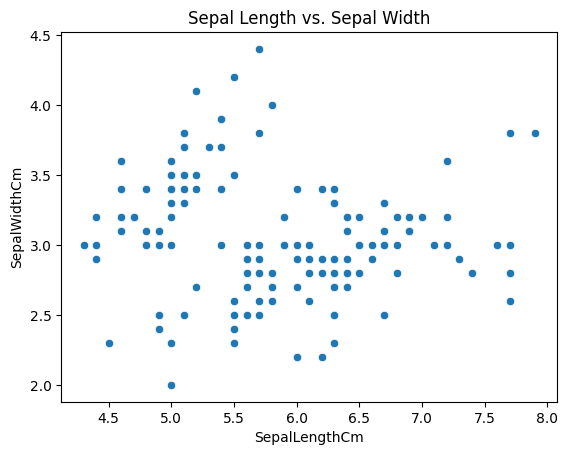

In [6]:
sns.scatterplot(x='SepalLengthCm', y='SepalWidthCm', data=iris)
plt.title('Sepal Length vs. Sepal Width')

# Scatter plot - Category

Text(0.5, 1.0, 'Sepal Length vs. Sepal Width')

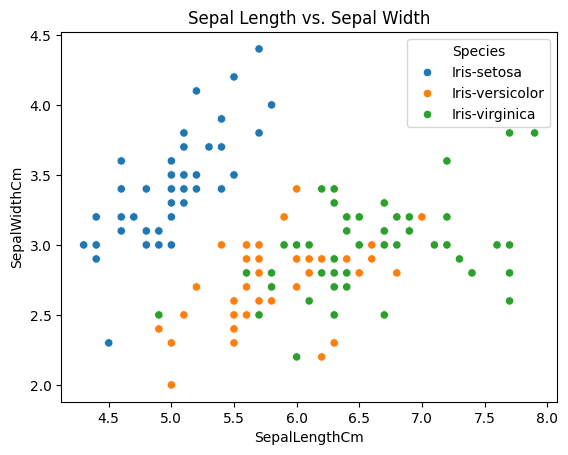

In [7]:
sns.scatterplot(x='SepalLengthCm', y='SepalWidthCm', hue = 'Species',data=iris)
plt.title('Sepal Length vs. Sepal Width')

# Scatter plot with regression Fit

Text(0.5, 1.0, 'Sepal Length vs. Sepal Width')

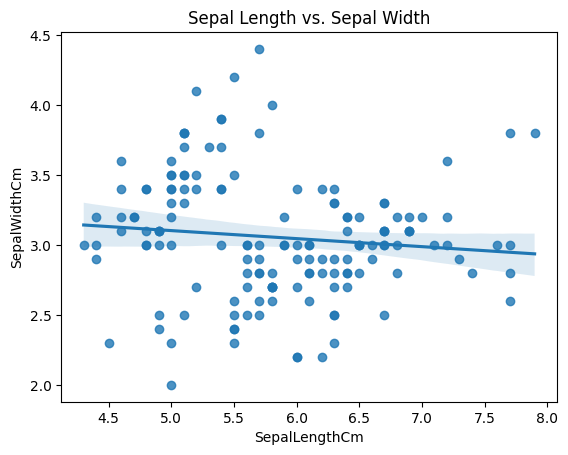

In [8]:
sns.regplot(x='SepalLengthCm', y='SepalWidthCm', data=iris)
plt.title('Sepal Length vs. Sepal Width')

# Control shape of element in Scatter Plot

Text(0.5, 1.0, 'Sepal Length vs. Sepal Width')

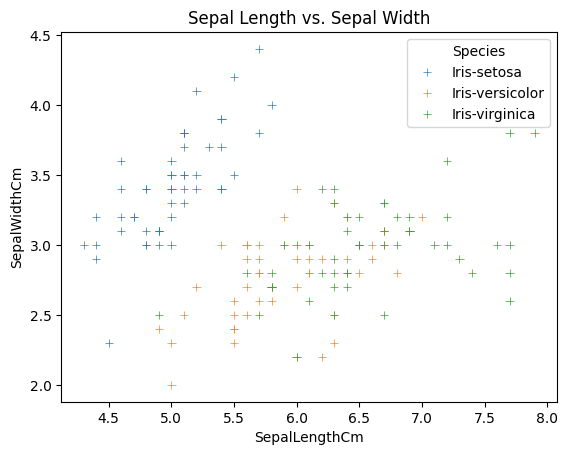

In [9]:
sns.scatterplot(x='SepalLengthCm', y='SepalWidthCm', data=iris , hue = 'Species' , marker = '+')
plt.title('Sepal Length vs. Sepal Width')

# Using color Palletes in Scatter plot

Text(0.5, 1.0, 'Age vs. Height')

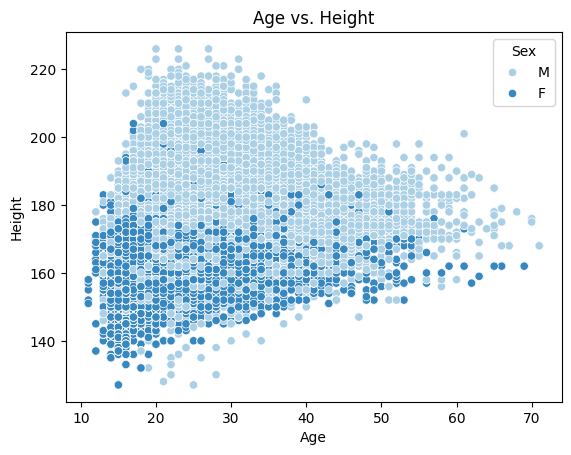

In [14]:

sns.scatterplot(x='Age', y='Height', hue='Sex', data=olympic, palette='Blues')
plt.title('Age vs. Height')

Text(0.5, 1.0, 'Age vs. Height')

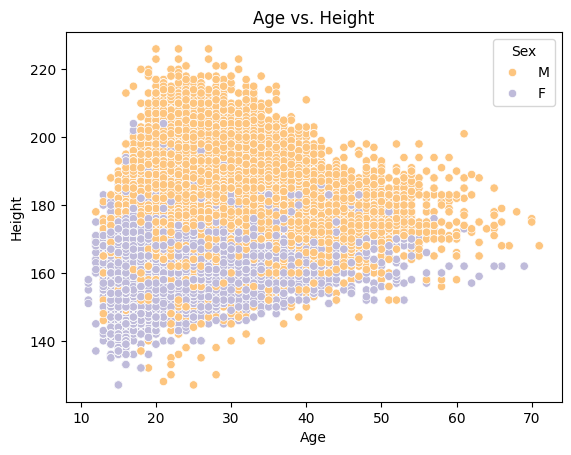

In [15]:
# using diverging color scheme
sns.scatterplot(x='Age', y='Height', hue='Sex', data=olympic, palette='PuOr')
plt.title('Age vs. Height')

Text(0.5, 1.0, 'Age vs. Height')

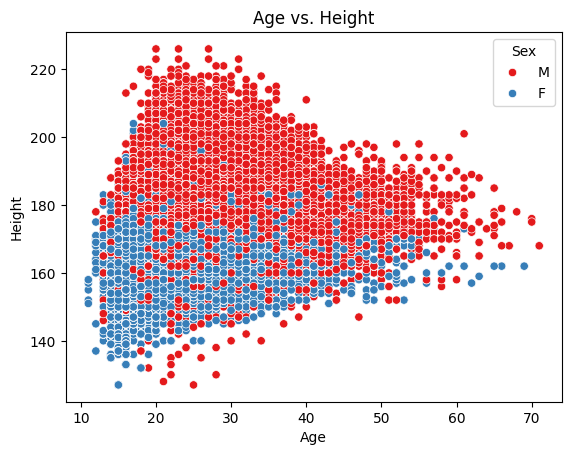

In [16]:
# using discrete color scheme
sns.scatterplot(x='Age', y='Height', hue='Sex', data=olympic, palette='Set1')
plt.title('Age vs. Height')

# Line plot

<Axes: xlabel='Age', ylabel='Height'>

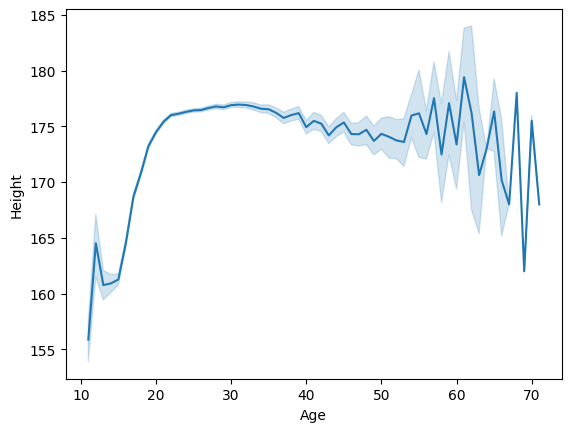

In [17]:
sns.lineplot(x='Age' , y ='Height', data = olympic)

<Axes: xlabel='Age', ylabel='Height'>

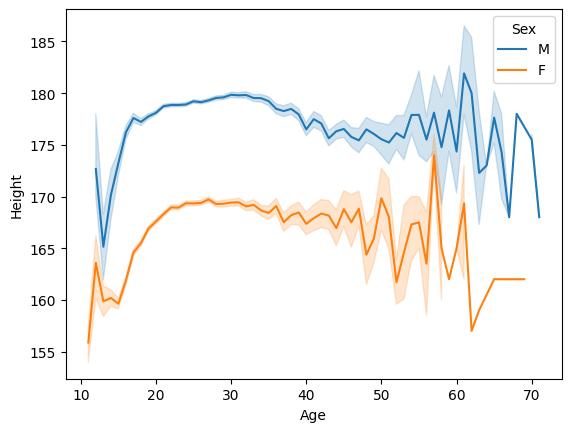

In [19]:
sns.lineplot(x='Age', y='Height', data=olympic, hue='Sex')

<Axes: xlabel='Age', ylabel='Height'>

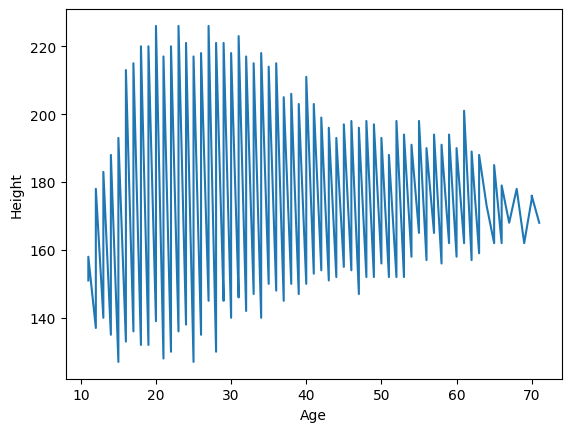

In [20]:
sns.lineplot(x='Age', y='Height', data=olympic, estimator = None)

# Histogram

<ipython-input-24-9c271d9bf42f>:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(olympic['Age'], bins=20)


<Axes: xlabel='Age', ylabel='Density'>

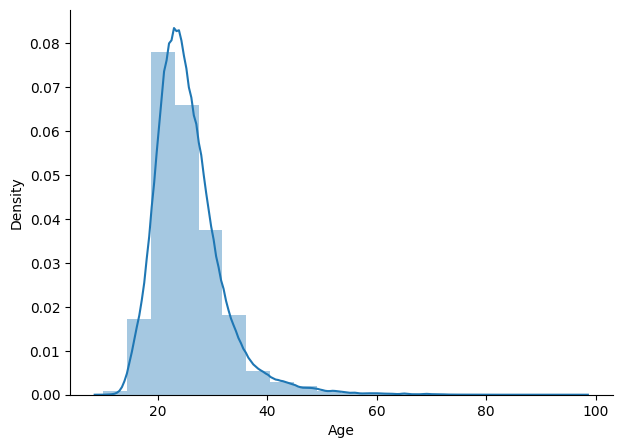

In [24]:
f, ax = plt.subplots(figsize=(7, 5))
sns.despine(f)
sns.distplot(olympic['Age'], bins=20)

<ipython-input-25-7d143b7c900f>:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(olympic['Age'], kde=False)


<Axes: xlabel='Age'>

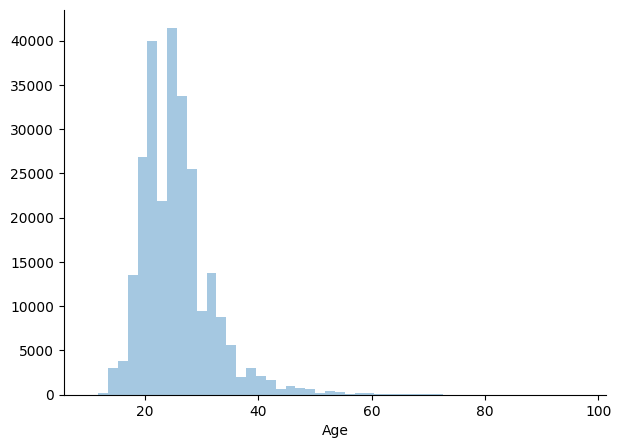

In [25]:
f, ax = plt.subplots(figsize=(7, 5))
sns.despine(f)
sns.distplot(olympic['Age'], kde=False)

# Basic 1D Density plot

<Axes: xlabel='PetalLengthCm', ylabel='Density'>

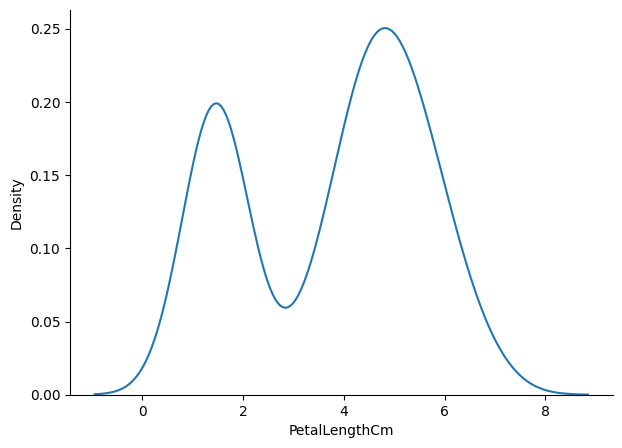

In [30]:
f, ax = plt.subplots(figsize=(7, 5))
sns.despine(f)
sns.kdeplot(iris['PetalLengthCm'])

<ipython-input-31-6a2f1598063a>:3: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(iris['PetalLengthCm'], shade = True)


<Axes: xlabel='PetalLengthCm', ylabel='Density'>

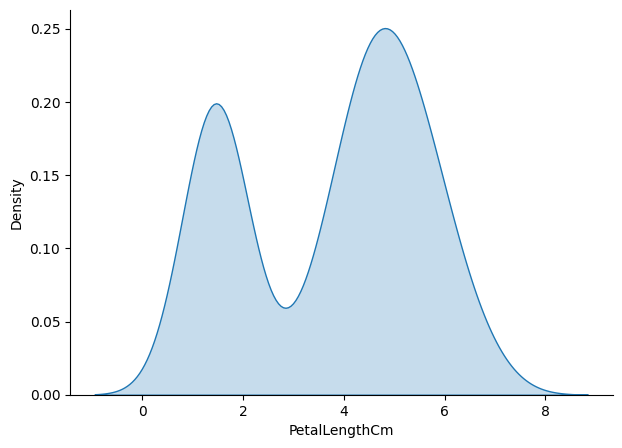

In [31]:
f, ax = plt.subplots(figsize=(7, 5))
sns.despine(f)
sns.kdeplot(iris['PetalLengthCm'], shade = True)

<ipython-input-34-88c0222105a5>:3: UserWarning: 

The `vertical` parameter is deprecated; assigning data to `y`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(iris['PetalLengthCm'], vertical = True)


<Axes: xlabel='Density', ylabel='PetalLengthCm'>

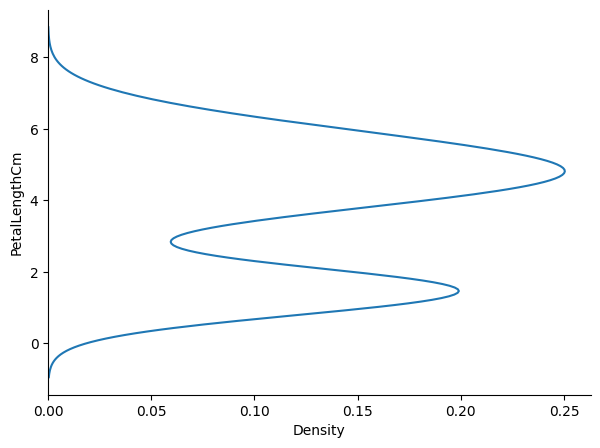

In [34]:
f, ax = plt.subplots(figsize=(7, 5))
sns.despine(f)
sns.kdeplot(iris['PetalLengthCm'], vertical = True)

<ipython-input-39-f48b09039c5c>:3: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(iris['PetalLengthCm'],   shade= True)
<ipython-input-39-f48b09039c5c>:4: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(iris['PetalLengthCm'],   shade = True)


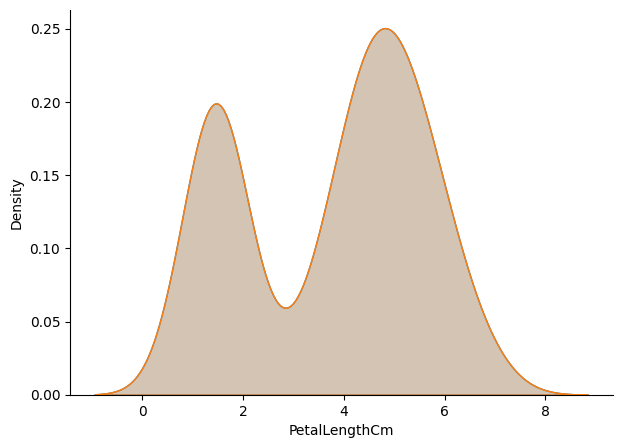

In [39]:
f, ax = plt.subplots(figsize=(7, 5))
sns.despine(f)
sns.kdeplot(iris['PetalLengthCm'],   shade= True)
sns.kdeplot(iris['PetalLengthCm'],   shade = True)
plt.show()

# Multi Variable Density Plot: Customize Color

<ipython-input-40-02f3e16e3983>:3: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(iris['SepalLengthCm'], shade=True, color='r')
<ipython-input-40-02f3e16e3983>:4: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(iris['SepalWidthCm'], shade=True, color='m')


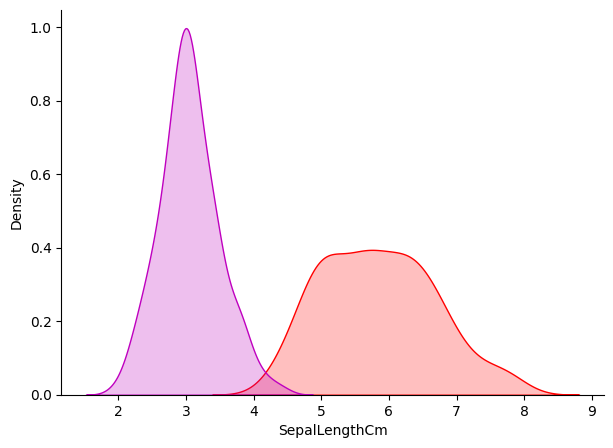

In [40]:
f, ax = plt.subplots(figsize=(7, 5))
sns.despine(f)
sns.kdeplot(iris['SepalLengthCm'], shade=True, color='r')
sns.kdeplot(iris['SepalWidthCm'], shade=True, color='m')
plt.show()

<ipython-input-41-f5d5e87901b7>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Species', y='SepalLengthCm', data=iris, palette='magma')


<Axes: xlabel='Species', ylabel='SepalLengthCm'>

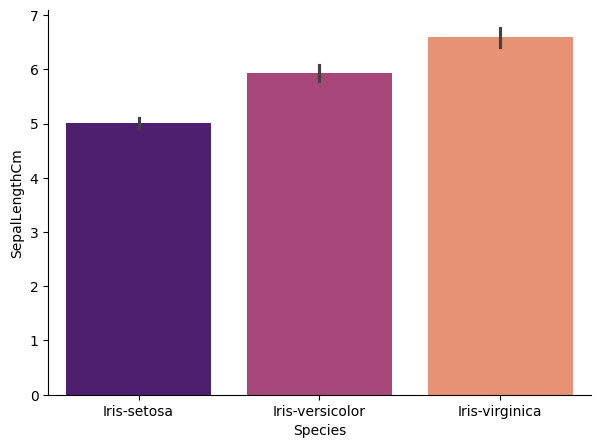

In [41]:
f, ax = plt.subplots(figsize=(7, 5))
sns.despine(f)
sns.barplot(x='Species', y='SepalLengthCm', data=iris, palette='magma')

<ipython-input-42-0fbd9e8aae40>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='SepalLengthCm', y='Species', data=iris, palette='magma', orient='h')


<Axes: xlabel='SepalLengthCm', ylabel='Species'>

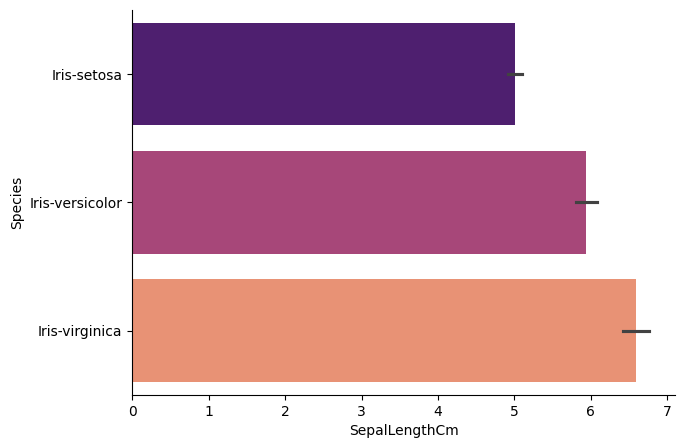

In [42]:
f, ax = plt.subplots(figsize=(7, 5))
sns.despine(f)
sns.barplot(x='SepalLengthCm', y='Species', data=iris, palette='magma', orient='h')

# BOX plot

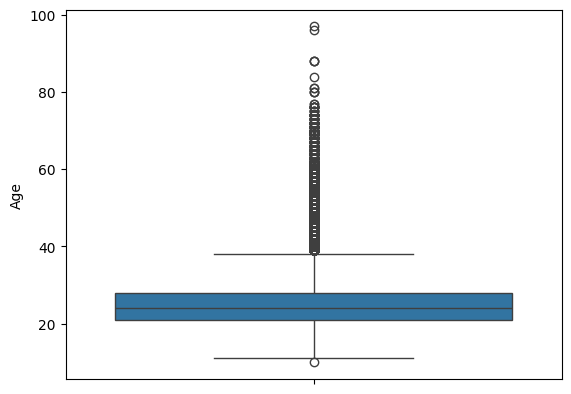

In [43]:
sns.boxplot(y=olympic['Age'])
plt.show()

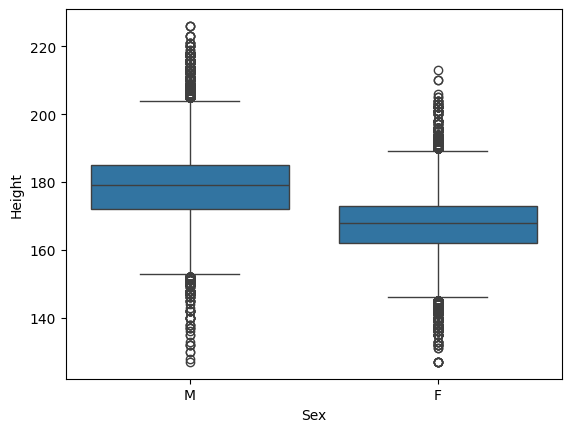

In [44]:
sns.boxplot(x=olympic['Sex'], y=olympic['Height'])
plt.show()

# Violin plot

<Axes: ylabel='age'>

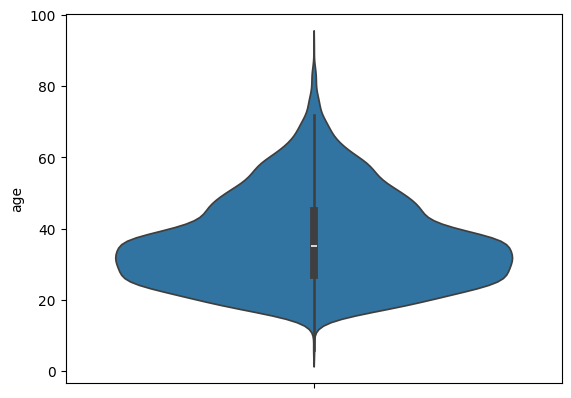

In [45]:
sns.violinplot(y=shootings['age'])

<Axes: xlabel='gender', ylabel='age'>

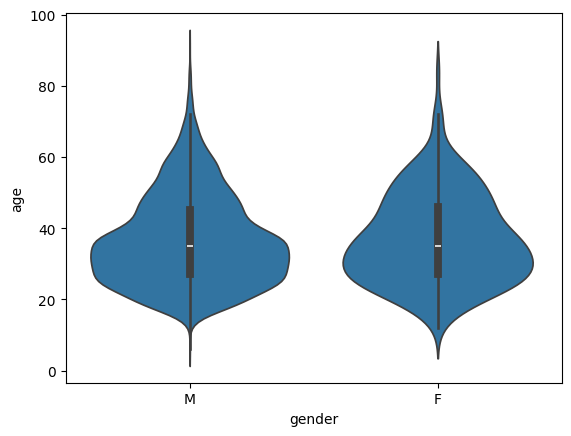

In [46]:
sns.violinplot(x=shootings['gender'], y=shootings['age'])

# Grid

Text(0.5, 1.0, 'Seaborn White Grid Theme')

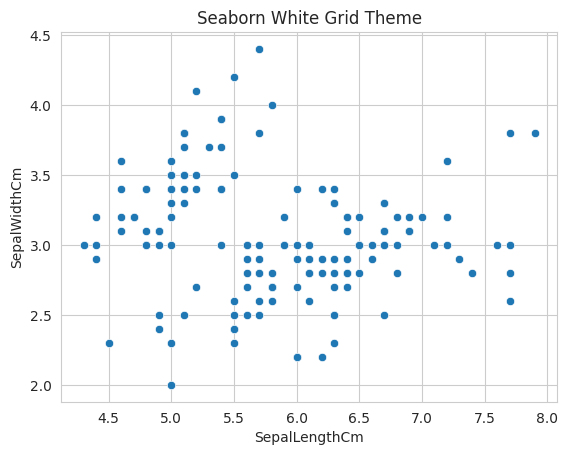

In [47]:
sns.set_style("whitegrid")
sns.scatterplot(x='SepalLengthCm', y='SepalWidthCm', data=iris)
plt.title("Seaborn White Grid Theme")